# Models Analysis

In [1]:
path   = './best_weights/'
t_path = './teacher-best_weight/'

## KD
KD_bert_distilbert_path      = path + 'KD_student_model.pt'
KD_bert_distilbert_hist_path = path + 'KD_training_hist.pt'

KD_bert_tinybert_path      = path + 'KD_TinyBert_student_model.pt'
KD_bert_tinybert_hist_path = path + 'KD_TinyBert_training_hist.pt'

KD_roberta_distilbert_path      = path + 'KD_roberta_distilbert_model.pt'
KD_roberta_distilbert_hist_path = path + 'KD_roberta_distilbert_training_hist.pt' 

## MetaDistil
metaDistil_bert_distilbert_path      = path + 'MetaKD_student_model.pt'
metaDistil_bert_distilbert_hist_path = path + 'MetaKD_training_hist.pt'

metaDistil_bert_tinybert_path      = path + 'MetaKD_TinyBert_student_model.pt'
metaDistil_bert_tinybert_hist_path = path + 'MetaKD_TinyBert_training_hist.pt'

metaDistil_roberta_distilbert_path      = path + 'MetaKD_roberta_distilbert_model.pt'
metaDistil_roberta_distilbert_hist_path = path + 'MetaKD_roberta_distilbert_training_hist.pt'


## Teacher
bert_model_path         = t_path + 'bert-base-uncased-SST-2.pt'
bert_training_hist_path = t_path + 'bert-base-uncased-SST-2_training_hist.pt' 

roberta_model_path         = t_path + 'roberta-base-SST-2.pt'
roberta_training_hist_path = t_path + 'roberta-base-SST-2_training_hist.pt'

## Student
distilbert_model_path         = t_path + 'distilbert-base-uncased-SST-2.pt'
distilbert_training_hist_path = t_path + 'distilbert-base-uncased-SST-2_training_hist.pt'

tinybert_model_path         = t_path + 'tinybert-SST-2.pt'
tinybert_training_hist_path = t_path + 'tinybert-SST-2_training_hist.pt'



## 1) Loading test set for our SST-2 part of the GLUE dataset

In [2]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

test_dataset      = load_dataset("glue", "sst2", split=["train[60000:62000]"])
bert_tokenizer    = AutoTokenizer.from_pretrained("distilbert-base-uncased")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

Found cached dataset glue (C:/Users/abhin/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
test_dataset

[Dataset({
     features: ['sentence', 'label', 'idx'],
     num_rows: 2000
 })]

In [4]:
from datasets import DatasetDict

In [5]:
test_dataset = DatasetDict({
    "test": test_dataset[0]
})

In [6]:
test_dataset

DatasetDict({
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 2000
    })
})

In [7]:
raw_test_dataset = test_dataset["test"]
raw_test_dataset[0]

{'sentence': 'manically generous ', 'label': 1, 'idx': 60000}

In [8]:
raw_test_dataset[5]['sentence']

'elegant and sly '

In [9]:
raw_test_dataset[5]['label']

1

In [10]:
raw_test_dataset[5]['idx']

60005

In [11]:
raw_test_dataset.features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

## 2) Preprocess

In [12]:
def bert_tokenize_function(example):
    return bert_tokenizer(example["sentence"], truncation=True)

def roberta_tokenize_function(example):
    return roberta_tokenizer(example["sentence"], truncation=True)

bert_tokenized_datasets    = test_dataset.map(bert_tokenize_function, batched=True)
roberta_tokenized_datasets = test_dataset.map(roberta_tokenize_function, batched=True)

bert_tokenized_datasets, roberta_tokenized_datasets

Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-8d5efb1b02ba6ccf.arrow
Loading cached processed dataset at C:\Users\abhin\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad\cache-ab5c6e92c61d4251.arrow


(DatasetDict({
     test: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 2000
     })
 }),
 DatasetDict({
     test: Dataset({
         features: ['sentence', 'label', 'idx', 'input_ids', 'attention_mask'],
         num_rows: 2000
     })
 }))

## 3) Preparing for Evaluation

In [13]:
from transformers import DataCollatorWithPadding

bert_data_collator    = DataCollatorWithPadding(tokenizer=bert_tokenizer)
roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

In [14]:
bert_tokenized_datasets = bert_tokenized_datasets.remove_columns(["sentence", "idx"])
bert_tokenized_datasets = bert_tokenized_datasets.rename_column("label", "labels")
bert_tokenized_datasets.set_format("torch")
bert_tokenized_datasets["test"].column_names

['labels', 'input_ids', 'attention_mask']

In [15]:
roberta_tokenized_datasets = roberta_tokenized_datasets.remove_columns(["sentence", "idx"])
roberta_tokenized_datasets = roberta_tokenized_datasets.rename_column("label", "labels")
roberta_tokenized_datasets.set_format("torch")
roberta_tokenized_datasets["test"].column_names

['labels', 'input_ids', 'attention_mask']

In [16]:
from torch.utils.data import DataLoader

bert_eval_dataloader = DataLoader(
    bert_tokenized_datasets["test"], batch_size=20, collate_fn=bert_data_collator
)

roberta_eval_dataloader = DataLoader(
    roberta_tokenized_datasets["test"], batch_size=20, collate_fn=roberta_data_collator
)

In [17]:
for batch in bert_eval_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([20]),
 'input_ids': torch.Size([20, 43]),
 'attention_mask': torch.Size([20, 43])}

## 4) Loading Models

In [18]:
# id2label, label2id dicts for the outputs for the model
labels = bert_tokenized_datasets["test"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [19]:
from transformers import AutoModelForSequenceClassification

distilbert_student = "distilbert-base-uncased"
tinybert_student   = "huawei-noah/TinyBERT_General_4L_312D"
bert_teacher       = "bert-base-uncased"
roberta_teacher    = "roberta-base"

## KD
KD_bert_distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    distilbert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

KD_bert_tinybert_model = AutoModelForSequenceClassification.from_pretrained(
    tinybert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

KD_roberta_distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    distilbert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

## MetaDistil
metaDistil_bert_distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    distilbert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

metaDistil_bert_tinybert_model = AutoModelForSequenceClassification.from_pretrained(
    tinybert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

metaDistil_roberta_distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    distilbert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

## Teacher
bert_model = AutoModelForSequenceClassification.from_pretrained(
    bert_teacher,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

roberta_model = AutoModelForSequenceClassification.from_pretrained(
    roberta_teacher,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

## Student
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    distilbert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

tinybert_model = AutoModelForSequenceClassification.from_pretrained(
    tinybert_student,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

### Load Pretrained Weights

In [20]:
import torch

In [21]:
best_KD_bert_distilbert_weight = torch.load(KD_bert_distilbert_path, map_location="cpu")
KD_bert_distilbert_model.load_state_dict(best_KD_bert_distilbert_weight['model_state_dict'])

<All keys matched successfully>

In [22]:
best_KD_bert_tinybert_weight = torch.load(KD_bert_tinybert_path, map_location="cpu")
KD_bert_tinybert_model.load_state_dict(best_KD_bert_tinybert_weight['model_state_dict'])

<All keys matched successfully>

In [23]:
best_KD_roberta_distilbert_weight = torch.load(KD_roberta_distilbert_path, map_location="cpu")
KD_roberta_distilbert_model.load_state_dict(best_KD_roberta_distilbert_weight['model_state_dict'])

<All keys matched successfully>

In [24]:
best_bert_distilbert_metaDistil_weight = torch.load(metaDistil_bert_distilbert_path, map_location="cpu")
metaDistil_bert_distilbert_model.load_state_dict(best_bert_distilbert_metaDistil_weight['model_state_dict'])

<All keys matched successfully>

In [25]:
best_metaDistil_bert_tinybert_weight = torch.load(metaDistil_bert_tinybert_path, map_location="cpu")
metaDistil_bert_tinybert_model.load_state_dict(best_metaDistil_bert_tinybert_weight['model_state_dict'])

<All keys matched successfully>

In [26]:
best_metaDistil_roberta_distilbert_weight = torch.load(metaDistil_roberta_distilbert_path, map_location="cpu")
metaDistil_roberta_distilbert_model.load_state_dict(best_metaDistil_roberta_distilbert_weight['model_state_dict'])

<All keys matched successfully>

In [27]:
best_bert_weight = torch.load(bert_model_path, map_location="cpu")
bert_model.load_state_dict(best_bert_weight['model_state_dict'])

<All keys matched successfully>

In [28]:
best_roberta_weight = torch.load(roberta_model_path, map_location="cpu")
roberta_model.load_state_dict(best_roberta_weight['model_state_dict'])

<All keys matched successfully>

In [29]:
best_distilbert_weight = torch.load(distilbert_model_path, map_location="cpu")
distilbert_model.load_state_dict(best_distilbert_weight['model_state_dict'])

<All keys matched successfully>

In [30]:
best_tinybert_weight = torch.load(tinybert_model_path, map_location="cpu")
tinybert_model.load_state_dict(best_tinybert_weight['model_state_dict'])

<All keys matched successfully>

## 5) Training Plots

### 5.1) Teacher Training Plots

In [31]:
bert_training_hist   = torch.load(bert_training_hist_path)
roberta_training_hist = torch.load(roberta_training_hist_path)

#### Loss Plot

In [32]:
from train_eval_func import plotLoss

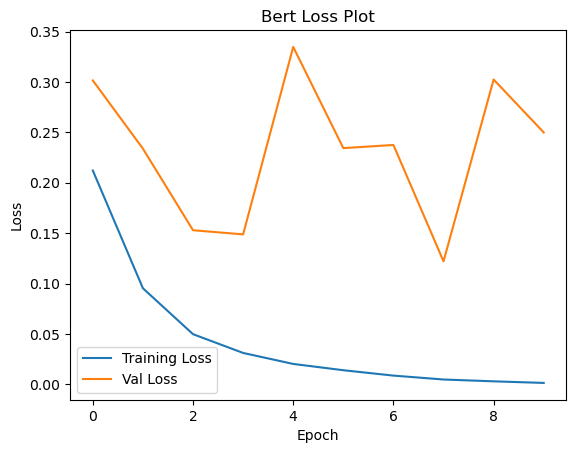

In [33]:
plotLoss(bert_training_hist['train_losses'], bert_training_hist['val_losses'], title='Bert Loss Plot')

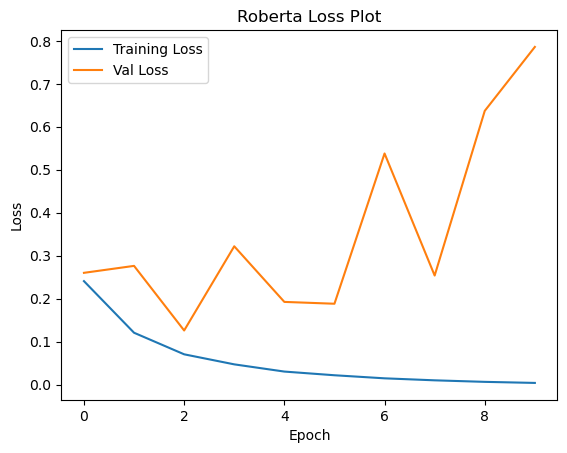

In [34]:
plotLoss(roberta_training_hist['train_losses'], roberta_training_hist['val_losses'], title='Roberta Loss Plot')

<b>Note:</b> Overfitting observed, especially in the case of Roberta

#### Accuracy Plot

In [35]:
from train_eval_func import plotAccuracy

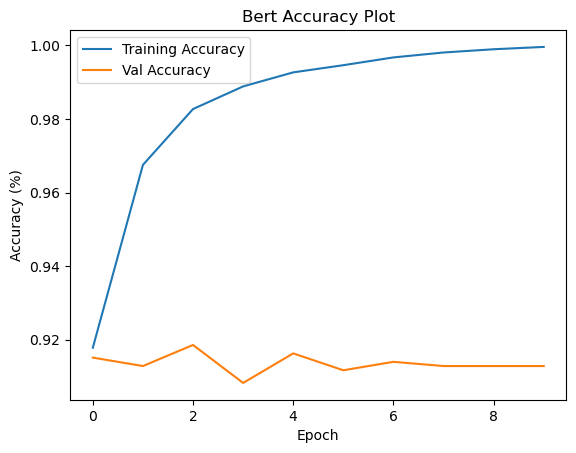

In [36]:
plotAccuracy(bert_training_hist['train_accs'], bert_training_hist['val_accs'], title='Bert Accuracy Plot')

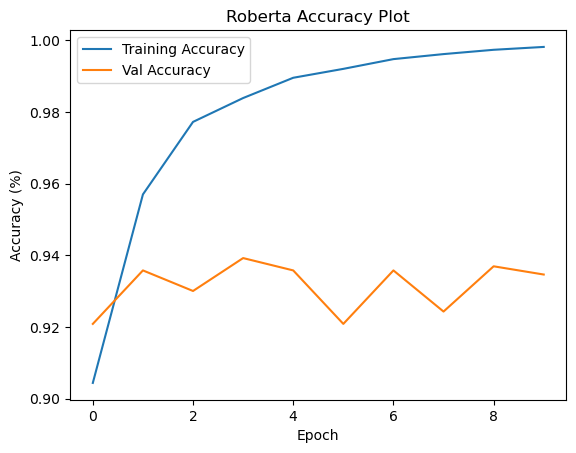

In [37]:
plotAccuracy(roberta_training_hist['train_accs'], roberta_training_hist['val_accs'], title='Roberta Accuracy Plot')

### 5.2) Pre-trained Models Fine-tuned Plots

In [38]:
distilbert_training_hist   = torch.load(distilbert_training_hist_path)
tinybert_training_hist = torch.load(tinybert_training_hist_path)

#### Loss Plot

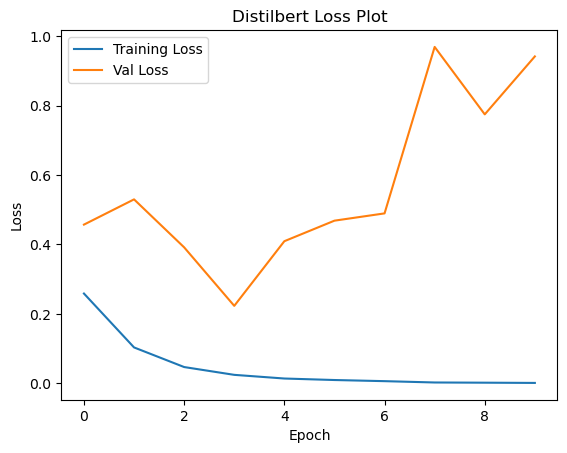

In [39]:
plotLoss(distilbert_training_hist['train_losses'], distilbert_training_hist['val_losses'], 
         title='Distilbert Loss Plot')

<b>Note:</b> Overfitting observed after 3rd epoch

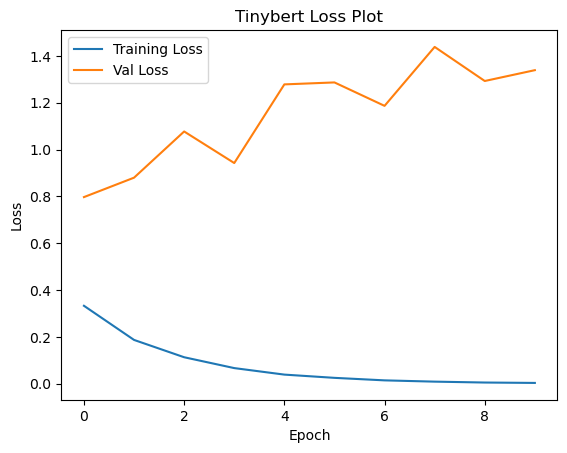

In [40]:
plotLoss(tinybert_training_hist['train_losses'], tinybert_training_hist['val_losses'], 
         title='Tinybert Loss Plot')

<b>Note:</b> Overfitting started from the very beginning of the training

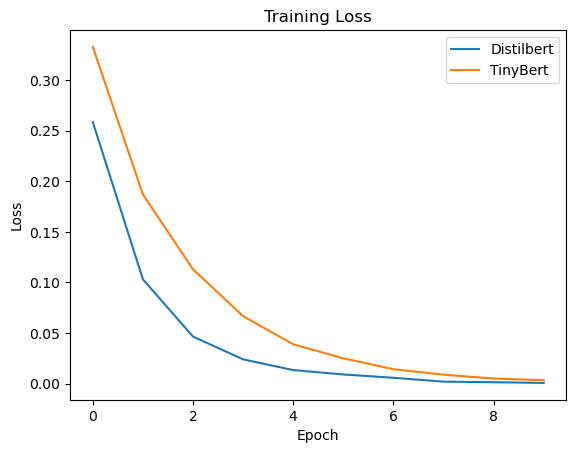

In [41]:
plotLoss(distilbert_training_hist['train_losses'], tinybert_training_hist['train_losses'], 
         ["Distilbert", "TinyBert"], 'Training Loss')

<b>Note:</b> Loss decreases for Distilbert faster but after certain epoch, both models seem to similar losses 

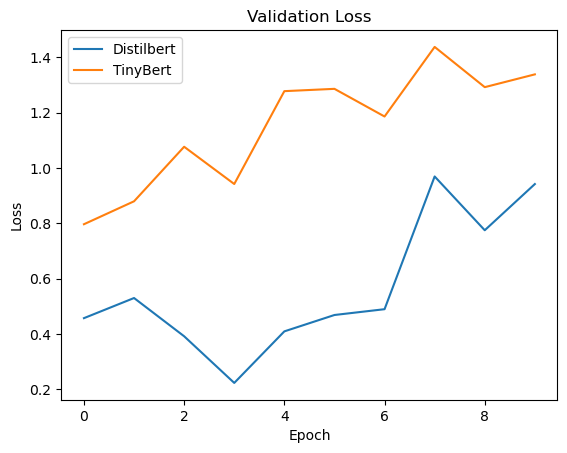

In [42]:
plotLoss(distilbert_training_hist['val_losses'], tinybert_training_hist['val_losses'], 
         ["Distilbert", "TinyBert"], 'Validation Loss')

#### Accuracy Plot

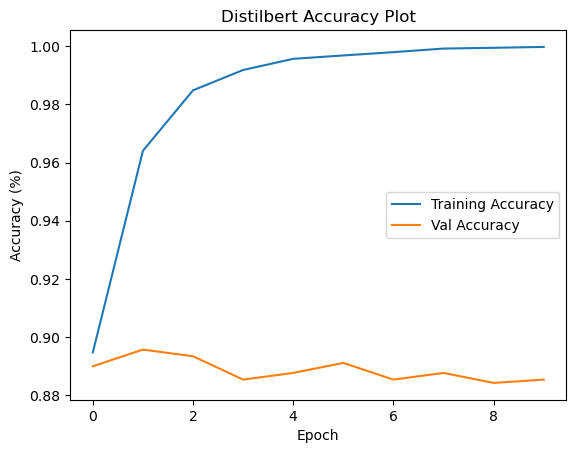

In [43]:
plotAccuracy(distilbert_training_hist['train_accs'], distilbert_training_hist['val_accs'], 
             title='Distilbert Accuracy Plot')

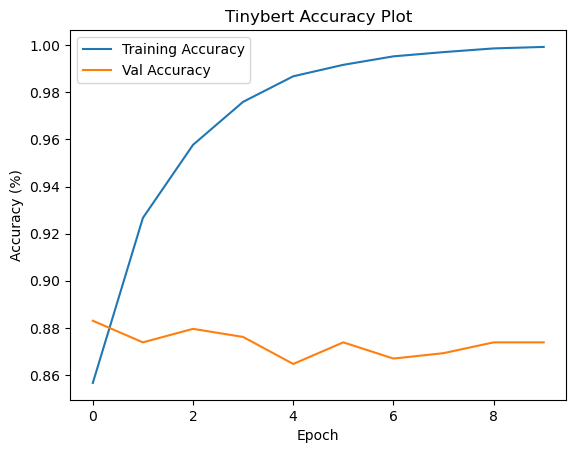

In [44]:
plotAccuracy(tinybert_training_hist['train_accs'], tinybert_training_hist['val_accs'], 
             title='Tinybert Accuracy Plot')

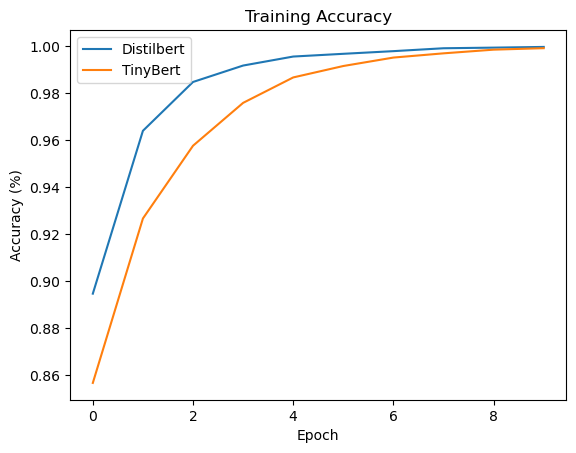

In [45]:
plotAccuracy(distilbert_training_hist['train_accs'], tinybert_training_hist['train_accs'], 
         ["Distilbert", "TinyBert"], 'Training Accuracy')

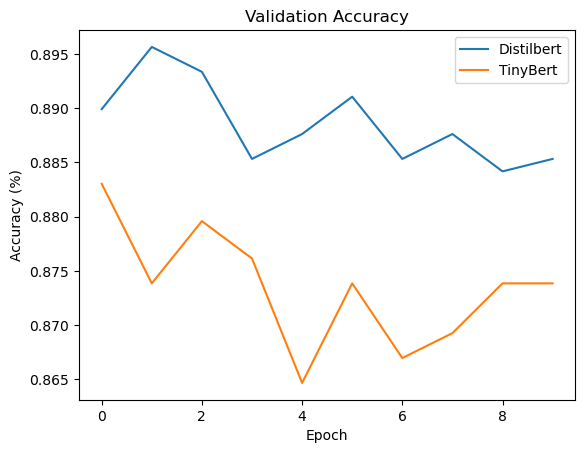

In [46]:
plotAccuracy(distilbert_training_hist['val_accs'], tinybert_training_hist['val_accs'], 
         ["Distilbert", "TinyBert"], 'Validation Accuracy')

### 5.3) Conventional Knowledge Distillation Plots

#### Teacher - Bert || Student - Distilbert

In [47]:
KD_bert_distilbert_hist = torch.load(KD_bert_distilbert_hist_path)

In [48]:
from train_eval_func import plotLoss

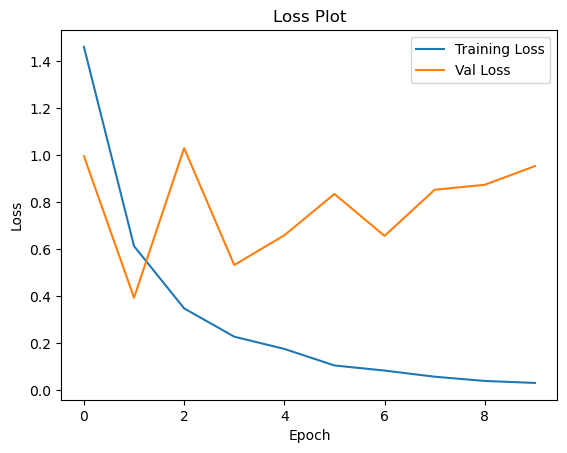

In [49]:
plotLoss(KD_bert_distilbert_hist['train_losses'], KD_bert_distilbert_hist['val_losses'], title="Loss Plot")

In [50]:
from train_eval_func import plotAccuracy

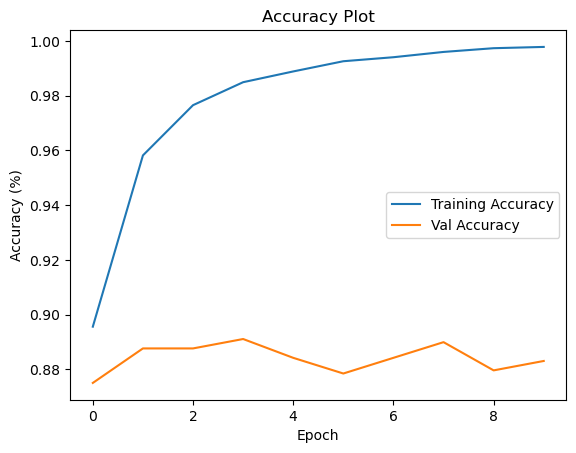

In [51]:
plotAccuracy(KD_bert_distilbert_hist['train_accs'], KD_bert_distilbert_hist['val_accs'],
            title="Accuracy Plot")

#### Teacher - Bert || Student - TinyBert

In [52]:
KD_bert_tinybert_hist = torch.load(KD_bert_tinybert_hist_path)

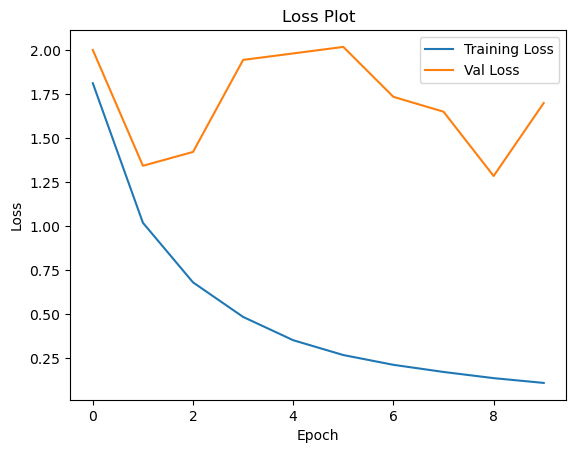

In [53]:
plotLoss(KD_bert_tinybert_hist['train_losses'], KD_bert_tinybert_hist['val_losses'], title="Loss Plot")

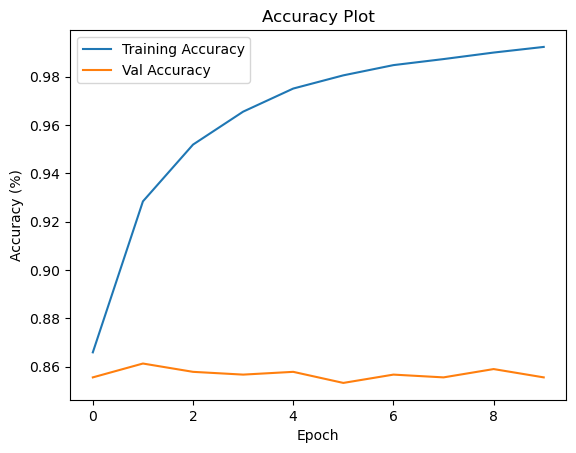

In [54]:
plotAccuracy(KD_bert_tinybert_hist['train_accs'], KD_bert_tinybert_hist['val_accs'],
            title="Accuracy Plot")

#### Teacher - Roberta || Student - Distilbert

In [55]:
KD_roberta_distilbert_hist = torch.load(KD_roberta_distilbert_hist_path)

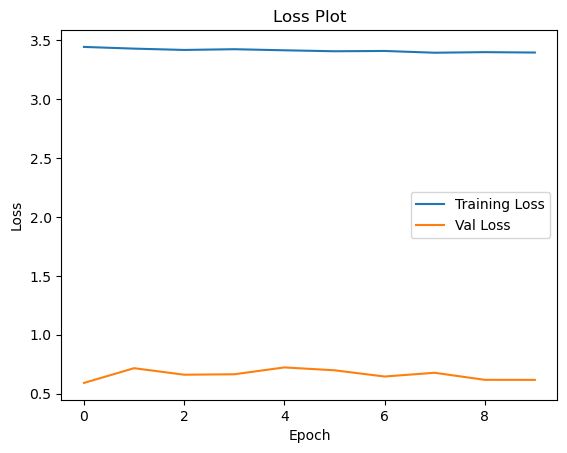

In [56]:
plotLoss(KD_roberta_distilbert_hist['train_losses'], KD_roberta_distilbert_hist['val_losses'],
         title="Loss Plot")

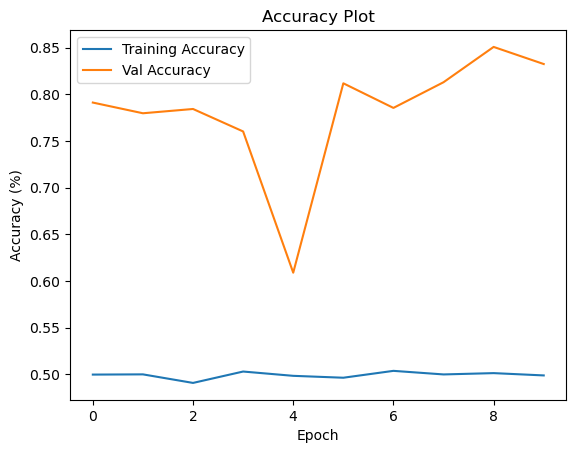

In [57]:
plotAccuracy(KD_roberta_distilbert_hist['train_accs'], KD_roberta_distilbert_hist['val_accs'],
            title="Accuracy Plot")

### 5.4) MetaDistil Plots

#### Teacher - Bert || Student - Distilbert

In [58]:
metaDistil_bert_distilbert_hist = torch.load(metaDistil_bert_distilbert_hist_path)

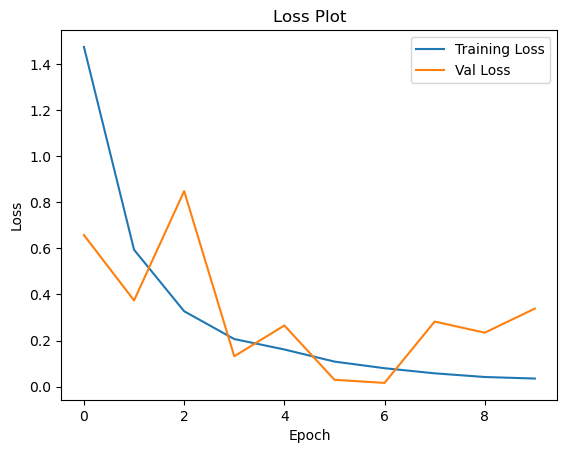

In [59]:
plotLoss(metaDistil_bert_distilbert_hist['train_losses'], metaDistil_bert_distilbert_hist['val_losses'],
        title="Loss Plot")

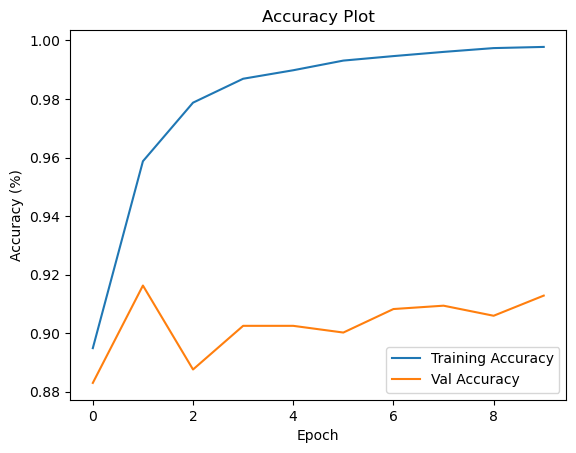

In [60]:
plotAccuracy(metaDistil_bert_distilbert_hist['train_accs'], metaDistil_bert_distilbert_hist['val_accs'],
            title="Accuracy Plot")

#### Teacher - Bert || Student - TinyBert

In [61]:
metaDistil_bert_tinybert_hist = torch.load(metaDistil_bert_tinybert_hist_path)

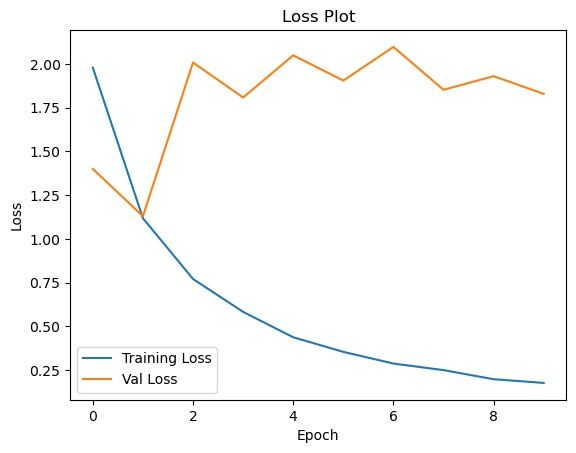

In [62]:
plotLoss(metaDistil_bert_tinybert_hist['train_losses'], metaDistil_bert_tinybert_hist['val_losses'],
        title="Loss Plot")

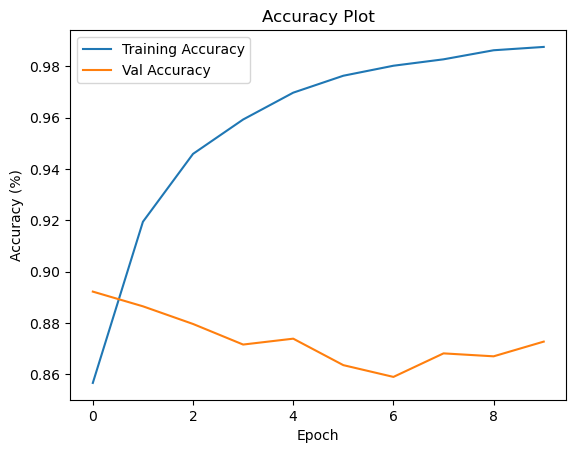

In [63]:
plotAccuracy(metaDistil_bert_tinybert_hist['train_accs'], metaDistil_bert_tinybert_hist['val_accs'],
            title="Accuracy Plot")

#### Teacher - Roberta || Student - Distilbert

In [64]:
metaDistil_roberta_distilbert_hist = torch.load(metaDistil_roberta_distilbert_hist_path)

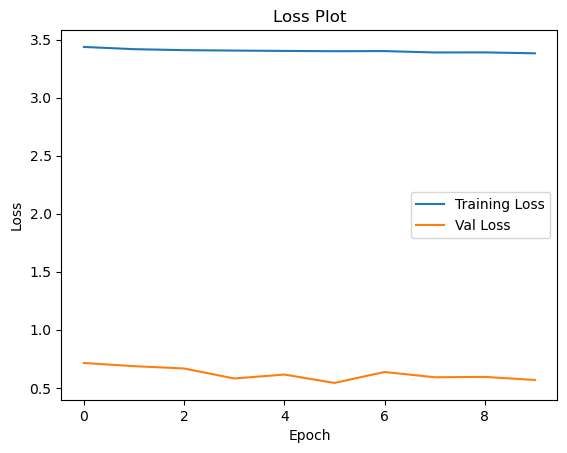

In [65]:
plotLoss(metaDistil_roberta_distilbert_hist['train_losses'], metaDistil_roberta_distilbert_hist['val_losses'],
        title="Loss Plot")

### 5.5) Conventional Knowledge Distillation and MetaDistil Comparision

#### Teacher - Bert || Student - Distilbert

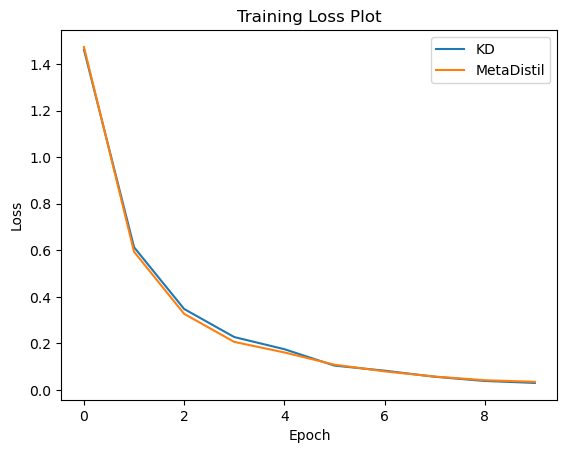

In [66]:
plotLoss(KD_bert_distilbert_hist['train_losses'], metaDistil_bert_distilbert_hist['train_losses'],
         ["KD", "MetaDistil"], title="Training Loss Plot")

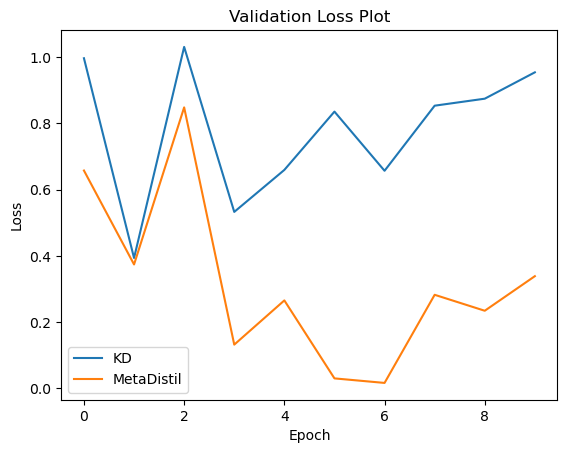

In [67]:
plotLoss(KD_bert_distilbert_hist['val_losses'], metaDistil_bert_distilbert_hist['val_losses'],
         ["KD", "MetaDistil"], title="Validation Loss Plot")

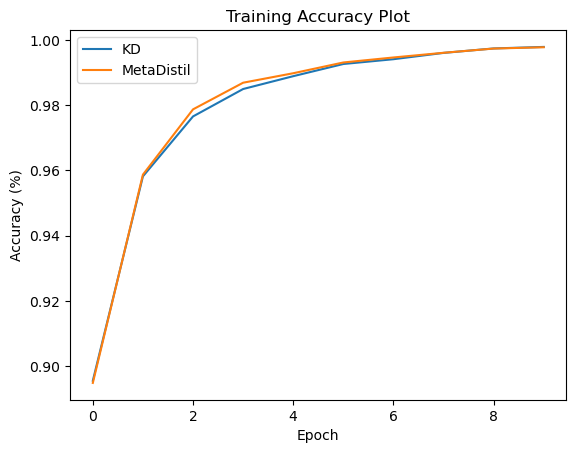

In [68]:
plotAccuracy(KD_bert_distilbert_hist['train_accs'], metaDistil_bert_distilbert_hist['train_accs'],
            ["KD", "MetaDistil"], title="Training Accuracy Plot")

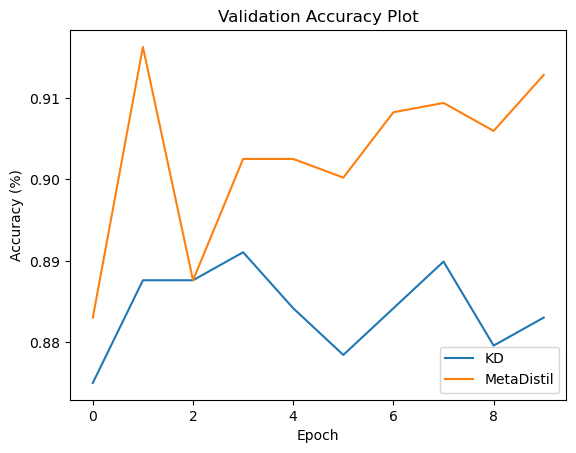

In [69]:
plotAccuracy(KD_bert_distilbert_hist['val_accs'], metaDistil_bert_distilbert_hist['val_accs'],
            ["KD", "MetaDistil"], title="Validation Accuracy Plot")

#### Teacher - Bert || Student - TinyBert

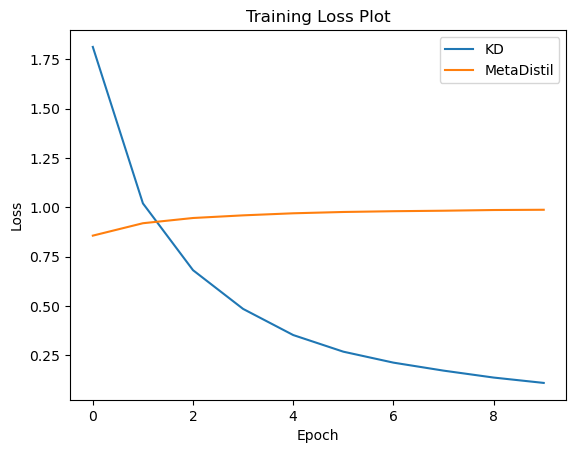

In [70]:
plotLoss(KD_bert_tinybert_hist['train_losses'], metaDistil_bert_tinybert_hist['train_accs'], 
         ["KD", "MetaDistil"], title="Training Loss Plot")

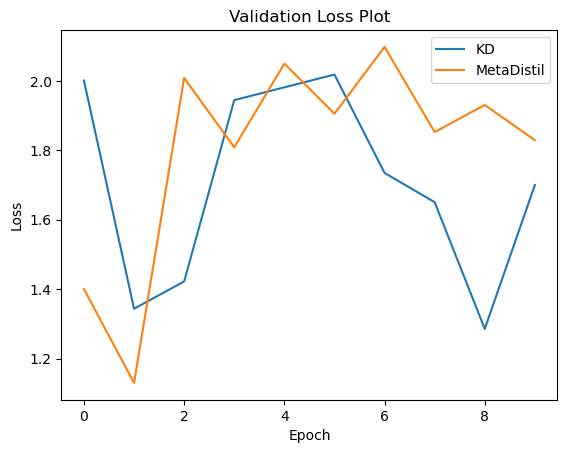

In [71]:
plotLoss(KD_bert_tinybert_hist['val_losses'], metaDistil_bert_tinybert_hist['val_losses'], 
         ["KD", "MetaDistil"], title="Validation Loss Plot")

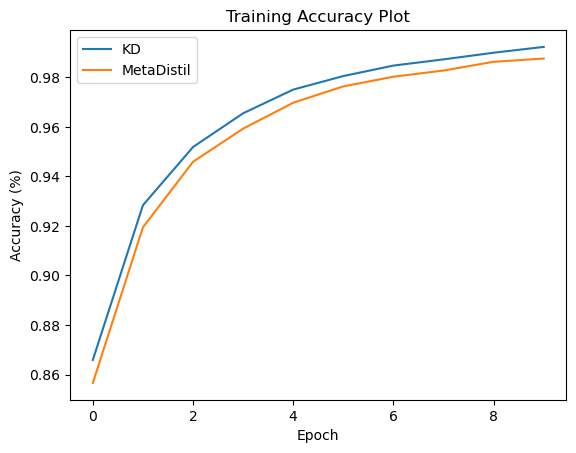

In [72]:
plotAccuracy(KD_bert_tinybert_hist['train_accs'], metaDistil_bert_tinybert_hist['train_accs'],
            ["KD", "MetaDistil"], title="Training Accuracy Plot")

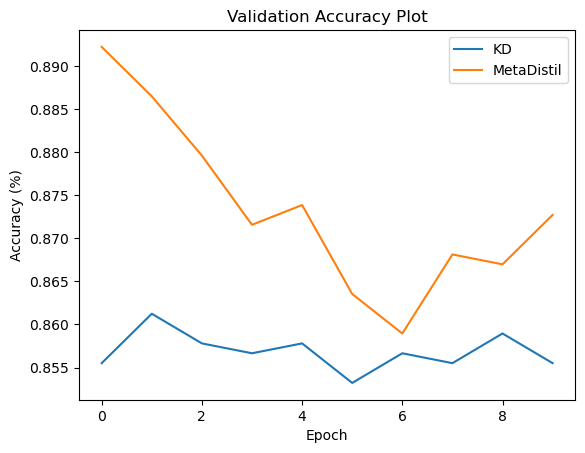

In [73]:
plotAccuracy(KD_bert_tinybert_hist['val_accs'], metaDistil_bert_tinybert_hist['val_accs'],
            ["KD", "MetaDistil"], title="Validation Accuracy Plot")

### 5.6) Teacher Comparision

#### Student - DistilBert

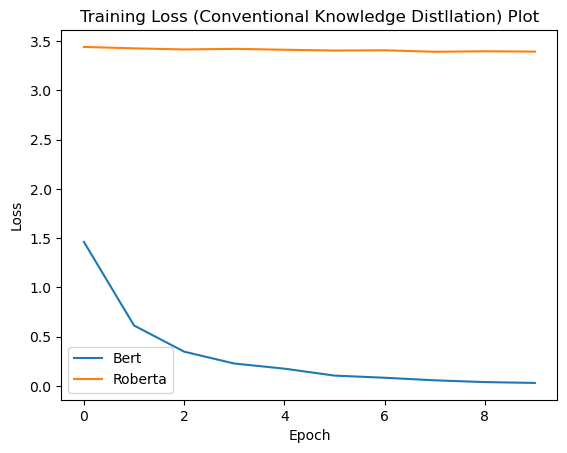

In [74]:
plotLoss(KD_bert_distilbert_hist['train_losses'], KD_roberta_distilbert_hist['train_losses'],
         ["Bert", "Roberta"], title="Training Loss (Conventional Knowledge Distllation) Plot")

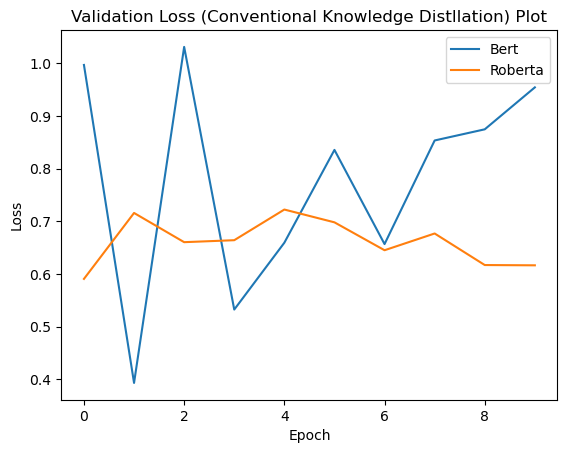

In [75]:
plotLoss(KD_bert_distilbert_hist['val_losses'], KD_roberta_distilbert_hist['val_losses'],
         ["Bert", "Roberta"], title="Validation Loss (Conventional Knowledge Distllation) Plot")

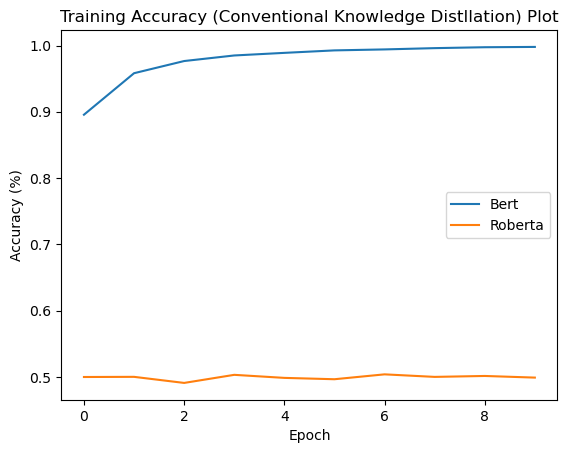

In [76]:
plotAccuracy(KD_bert_distilbert_hist['train_accs'], KD_roberta_distilbert_hist['train_accs'],
            ["Bert", "Roberta"], title="Training Accuracy (Conventional Knowledge Distllation) Plot")

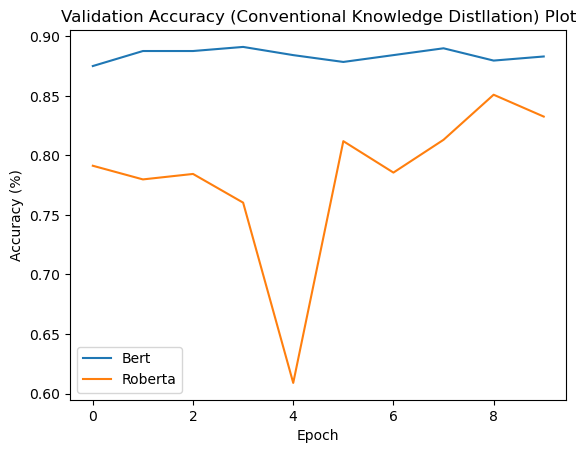

In [77]:
plotAccuracy(KD_bert_distilbert_hist['val_accs'], KD_roberta_distilbert_hist['val_accs'],
            ["Bert", "Roberta"], title="Validation Accuracy (Conventional Knowledge Distllation) Plot")

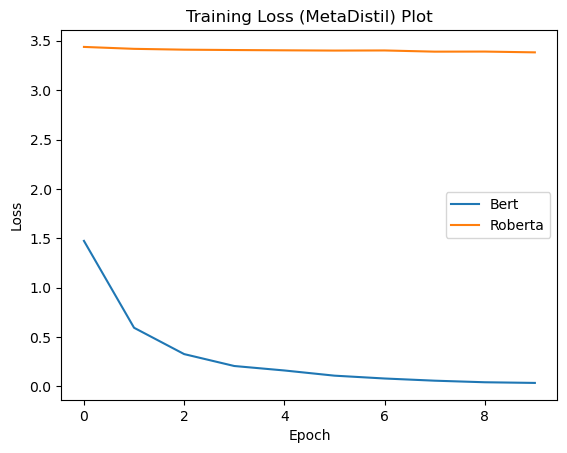

In [78]:
plotLoss(metaDistil_bert_distilbert_hist['train_losses'], metaDistil_roberta_distilbert_hist['train_losses'],
         ["Bert", "Roberta"], title="Training Loss (MetaDistil) Plot")

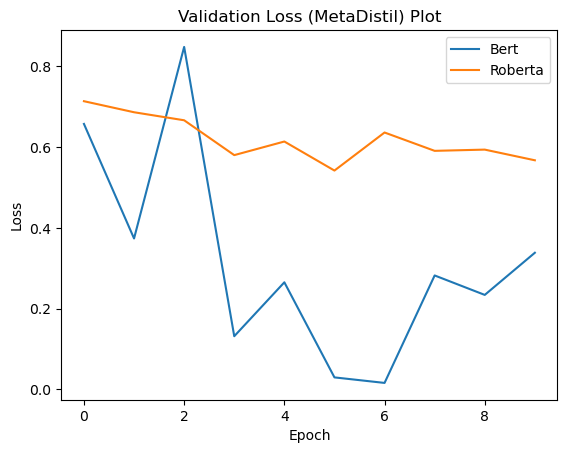

In [79]:
plotLoss(metaDistil_bert_distilbert_hist['val_losses'], metaDistil_roberta_distilbert_hist['val_losses'],
         ["Bert", "Roberta"], title="Validation Loss (MetaDistil) Plot")

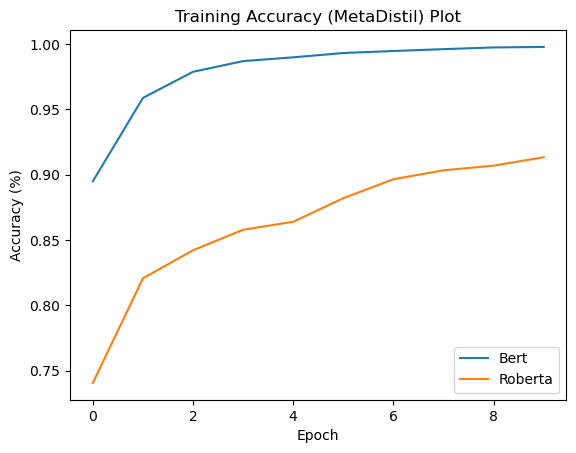

In [80]:
plotAccuracy(metaDistil_bert_distilbert_hist['train_accs'], metaDistil_roberta_distilbert_hist['train_accs'],
            ["Bert", "Roberta"], title="Training Accuracy (MetaDistil) Plot")

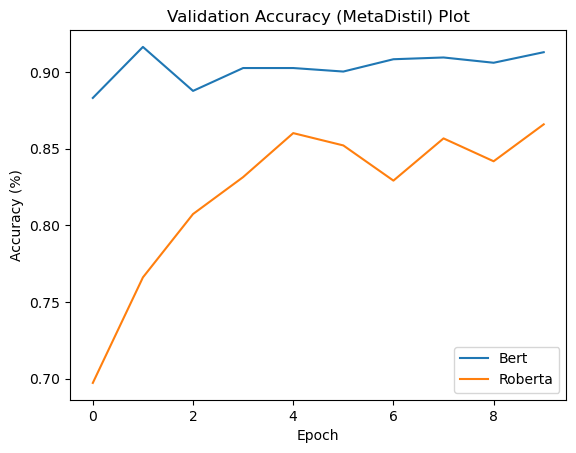

In [81]:
plotAccuracy(metaDistil_bert_distilbert_hist['val_accs'], metaDistil_roberta_distilbert_hist['val_accs'],
            ["Bert", "Roberta"], title="Validation Accuracy (MetaDistil) Plot")

## 6) Training Time Summary

In [82]:
from tabulate import tabulate

In [83]:
bert_total_train_time = bert_training_hist['total_train_time'] / 3600
roberta_total_train_time = roberta_training_hist['total_train_time'] / 3600

distilbert_total_train_time = distilbert_training_hist['total_train_time'] / 3600
tinybert_total_train_time = tinybert_training_hist['total_train_time'] / 3600

KD_total_train_time = (KD_bert_distilbert_hist['total_train_time'] + KD_bert_tinybert_hist['total_train_time'] 
                         + KD_roberta_distilbert_hist['total_train_time']) / (3 * 3600)

metaDistil_total_train_time = (metaDistil_bert_distilbert_hist['total_train_time'] 
                               + metaDistil_bert_tinybert_hist['total_train_time'] 
                               + metaDistil_roberta_distilbert_hist['total_train_time']) / (3 * 3600)

In [84]:
total_train_data = [
    ["Bert", bert_total_train_time],
    ["Roberta", roberta_total_train_time],
    ["Distilbert", distilbert_total_train_time],
    ["Tinybert", tinybert_total_train_time],
    ["KD", KD_total_train_time],
    ["MetaDistil", metaDistil_total_train_time]
]
 
total_train_head = ["Methods", "Total Training Time"]

print(tabulate(total_train_data, headers=total_train_head, tablefmt="grid"), end="\n\n")

+------------+-----------------------+
| Methods    |   Total Training Time |
+============+=======================+
| Bert       |             1.11441   |
+------------+-----------------------+
| Roberta    |             1.22191   |
+------------+-----------------------+
| Distilbert |             0.308156  |
+------------+-----------------------+
| Tinybert   |             0.0986935 |
+------------+-----------------------+
| KD         |             0.453678  |
+------------+-----------------------+
| MetaDistil |             1.16448   |
+------------+-----------------------+



## 7) Evaluation

In [85]:
from train_eval_func import eval_loop

In [86]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [87]:
## KD
KD_bert_distilbert_model.to(device)
KD_bert_tinybert_model.to(device)
KD_roberta_distilbert_model.to(device)

## MetaDistil
metaDistil_bert_distilbert_model.to(device)
metaDistil_bert_tinybert_model.to(device)
metaDistil_roberta_distilbert_model.to(device)

## Teachers
bert_model.to(device)
roberta_model.to(device)

## Students
distilbert_model.to(device)
tinybert_model.to(device)

device

device(type='cuda')

In [88]:
# def count_parameters(model):
#     params = [p.numel() for p in model.parameters() if p.requires_grad]
#     for item in params:
#         print(f'{item:>6}')
#     print(f'______\n{sum(params):>6}')

In [89]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    return sum(params)

In [90]:
## KD
KD_bert_distilbert_model_para     = count_parameters(KD_bert_distilbert_model)
KD_bert_tinybert_model_para = count_parameters(KD_bert_tinybert_model)
KD_roberta_distilbert_model_para  = count_parameters(KD_roberta_distilbert_model)

## MetaDistil
metaDistil_bert_distilbert_model_para     = count_parameters(metaDistil_bert_distilbert_model)
metaDistil_bert_tinybert_model_para       = count_parameters(metaDistil_bert_tinybert_model)
metaDistil_roberta_distilbert_model_para  = count_parameters(metaDistil_roberta_distilbert_model)

## Teachers
bert_model_para    = count_parameters(bert_model)
roberta_model_para = count_parameters(roberta_model)

## Students
distilbert_model_para = count_parameters(distilbert_model)
tinybert_model_para = count_parameters(tinybert_model)

### KD Model Accuracy

In [91]:
KD_bert_distilbert_acc = eval_loop(KD_bert_distilbert_model, bert_eval_dataloader, device)[0]['accuracy']
KD_bert_distilbert_acc

0.929

In [92]:
KD_bert_tinybert_acc = eval_loop(KD_bert_tinybert_model, bert_eval_dataloader, device)[0]['accuracy']
KD_bert_tinybert_acc

0.9245

In [93]:
KD_roberta_distilbert_acc = eval_loop(KD_roberta_distilbert_model, bert_eval_dataloader, device)[0]['accuracy']
KD_roberta_distilbert_acc

0.882

### MetaDistil Model Accuracy

In [94]:
metaDistil_bert_distilbert_acc = eval_loop(metaDistil_bert_distilbert_model, bert_eval_dataloader, 
                                           device)[0]['accuracy']
metaDistil_bert_distilbert_acc

0.935

In [95]:
metaDistil_bert_tinybert_acc = eval_loop(metaDistil_bert_tinybert_model, bert_eval_dataloader, 
                                         device)[0]['accuracy']
metaDistil_bert_tinybert_acc

0.921

In [96]:
metaDistil_roberta_distilbert_acc = eval_loop(metaDistil_roberta_distilbert_model, bert_eval_dataloader, 
                                              device)[0]['accuracy']
metaDistil_roberta_distilbert_acc

0.893

### Bert Model Accuracy

In [97]:
bert_acc = eval_loop(bert_model, bert_eval_dataloader, device)[0]['accuracy']
bert_acc

0.9535

### Roberta Model Accuracy

In [98]:
roberta_acc = eval_loop(roberta_model, roberta_eval_dataloader, device)[0]['accuracy']
roberta_acc

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


0.954

### Distilbert Model Accuracy

In [99]:
distilbert_acc = eval_loop(distilbert_model, bert_eval_dataloader, device)[0]['accuracy']
distilbert_acc

0.933

### Tinybert Model Accuracy

In [100]:
tinybert_acc = eval_loop(tinybert_model, bert_eval_dataloader, device)[0]['accuracy']
tinybert_acc

0.9245

### Summary

In [101]:
## KD
KD_bert_distilbert_model_para     = count_parameters(KD_bert_distilbert_model)
KD_bert_tinybert_model_para = count_parameters(KD_bert_tinybert_model)
KD_roberta_distilbert_model_para  = count_parameters(KD_roberta_distilbert_model)

## MetaDistil
metaDistil_bert_distilbert_model_para     = count_parameters(metaDistil_bert_distilbert_model)
metaDistil_bert_tinybert_model_para       = count_parameters(metaDistil_bert_tinybert_model)
metaDistil_roberta_distilbert_model_para  = count_parameters(metaDistil_roberta_distilbert_model)

## Teachers
bert_model_para    = count_parameters(bert_model)
roberta_model_para = count_parameters(roberta_model)

## Students
distilbert_model_para = count_parameters(distilbert_model)
tinybert_model_para = count_parameters(tinybert_model)

In [103]:
t_data = [
    ["Bert", bert_acc, bert_model_para],
    ["Roberta", roberta_acc, roberta_model_para]
]
 
t_head = ["Model", "Accuracy", "No. of Parameters"]

print("Teacher")
print(tabulate(t_data, headers=t_head, tablefmt="grid"), end="\n\n")


s_data = [
    ["Distilbert", distilbert_acc, distilbert_model_para],
    ["Tinybert", tinybert_acc, tinybert_model_para],
    
    ["Bert Distilbert KD", KD_bert_distilbert_acc, KD_bert_distilbert_model_para],
    ["Bert Tinybert KD", KD_bert_tinybert_acc, KD_bert_tinybert_model_para],
    ["Roberta Distilbert KD", KD_roberta_distilbert_acc, KD_roberta_distilbert_model_para],
    
    ["Bert Distilbert MetaDistil", metaDistil_bert_distilbert_acc, metaDistil_bert_distilbert_model_para],
    ["Bert Tinybert MetaDistil", metaDistil_bert_tinybert_acc, metaDistil_bert_tinybert_model_para],
    ["Roberta Distilbert MetaDistil", metaDistil_roberta_distilbert_acc, metaDistil_roberta_distilbert_model_para]
]
 
s_head = ["Methods", "Accuracy", "No. of Parameters"]

print("Student")
print(tabulate(s_data, headers=s_head, tablefmt="grid"))


Teacher
+---------+------------+---------------------+
| Model   |   Accuracy |   No. of Parameters |
+=========+============+=====================+
| Bert    |     0.9535 |           109483778 |
+---------+------------+---------------------+
| Roberta |     0.954  |           124647170 |
+---------+------------+---------------------+

Student
+-------------------------------+------------+---------------------+
| Methods                       |   Accuracy |   No. of Parameters |
+===============================+============+=====================+
| Distilbert                    |     0.933  |            66955010 |
+-------------------------------+------------+---------------------+
| Tinybert                      |     0.9245 |            14350874 |
+-------------------------------+------------+---------------------+
| Bert Distilbert KD            |     0.929  |            66955010 |
+-------------------------------+------------+---------------------+
| Bert Tinybert KD              |